### ESC-3 audio classification

This notebook is an example of audio classification using convolutional neural network.
<br>
The data is based on [ESC-50](https://github.com/karoldvl/ESC-50), which consists of 50 classes of environmental audio dataset.<br>
Data corresponding to three classes are selected from ESC-50.  
One data is in .wav format with 5 seconds each, 40 files per classes, so 120 files in total.

#### Import libraries  

In [1]:
import os, shutil
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import IPython.display as ipd

#### Parameters  

In [2]:
# sampling rate
s_rate = 8820
n_fft = 1024
hop_length = 128
n_mels = 128

# define directories
base_dir = './'
esc_dir = os.path.join(base_dir, 'ESC3')
meta_file = os.path.join(esc_dir, 'meta/esc3.csv')
audio_dir = os.path.join(esc_dir, 'audio/')
model_file = 'esc3-model-sr{}.h5'.format(s_rate)

# To show more rows and columns without "..."
pd.options.display.max_columns=999
pd.options.display.max_rows=999

#### Read CSV file (meta data)  

In [3]:
# load metadata
meta_data = pd.read_csv(meta_file, delimiter=',', skiprows=0, header=0)
print(meta_data.shape)
display(meta_data.head())

(120, 7)


,filename,fold,target,category,esc10,src_file,take
0,1-104089-A-22.wav,1,22,clapping,False,104089,A
1,1-104089-B-22.wav,1,22,clapping,False,104089,B
2,1-105224-A-22.wav,1,22,clapping,False,105224,A
3,1-110537-A-22.wav,1,22,clapping,False,110537,A
4,1-115920-A-22.wav,1,22,clapping,False,115920,A


#### Replace target into sequence number as class ID   

In [4]:
tgt_vc = meta_data['target'].value_counts()
n_classes = len(tgt_vc.index)
display(tgt_vc)

meta_data['target'] = meta_data['target'].replace(tgt_vc.index, list(range(n_classes)))
display(meta_data.head())

cat = meta_data['category']
classes = []
for i in range(n_classes):
    sel = cat[meta_data['target']==i].reset_index(drop=True)
    classes.append(sel[0])
print(classes)

22    40
25    40
38    40
Name: target, dtype: int64

,filename,fold,target,category,esc10,src_file,take
0,1-104089-A-22.wav,1,0,clapping,False,104089,A
1,1-104089-B-22.wav,1,0,clapping,False,104089,B
2,1-105224-A-22.wav,1,0,clapping,False,105224,A
3,1-110537-A-22.wav,1,0,clapping,False,110537,A
4,1-115920-A-22.wav,1,0,clapping,False,115920,A


['clapping', 'footsteps', 'clock_tick']


#### Definitions of functions  

In [5]:
# load a wave data
def load_wave_data(audio_dir, file_name):
    file_path = os.path.join(audio_dir, file_name)
    x, fs = librosa.load(file_path, sr=s_rate)
    return x,fs

In [6]:
# change wave data to mel-stft
def calculate_melsp(x, sr, n_fft=1024, hop_length=128, n_mels=128):
    stft = np.abs(librosa.stft(x, n_fft=n_fft, hop_length=hop_length))**2
    melsp = librosa.feature.melspectrogram(S=stft, sr=sr, n_mels=n_mels)
    log_melsp = librosa.power_to_db(melsp)
    #print(log_melsp[:3])  # debug
    return log_melsp

In [7]:
# display wave in plots
def show_wave(x):
    plt.plot(x)
    plt.show()

In [8]:
# display wave in heatmap
def show_melsp(melsp, fs):
    librosa.display.specshow(melsp, sr=fs)
    plt.colorbar()
    plt.show()

#### load data  

wave size: (44100,)
melsp size: (128, 345)
sampling rate: 8820


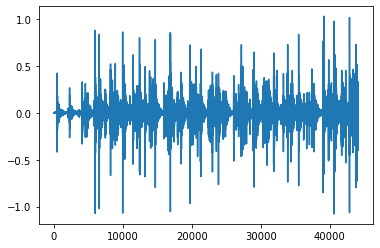

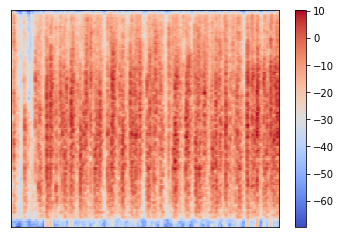

In [9]:
# example data
x, fs = load_wave_data(audio_dir, meta_data.loc[0,"filename"])
melsp = calculate_melsp(x, s_rate, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
print('wave size:', x.shape)
print('melsp size:', melsp.shape)
print('sampling rate:', fs)
show_wave(x)
show_melsp(melsp, fs)

In [10]:
ipd.Audio(x, rate=fs)

#### Split training and test dataset  

In [11]:
# get training dataset and target dataset
filenames = meta_data.loc[:,"filename"]
targets = meta_data.loc[:, "target"]

f_train, f_test, t_train, t_test = train_test_split(filenames, targets, test_size=0.25, stratify=targets)
f_train = f_train.reset_index(drop=True)
t_train = t_train.reset_index(drop=True)
f_test = f_test.reset_index(drop=True)
t_test = t_test.reset_index(drop=True)

print('Number of data:')
print('f_train:', f_train.shape[0])
print('t_train:', t_train.shape[0])
print('f_test:', f_test.shape[0])
print('t_test:', t_test.shape[0])

Number of data:
f_train: 90
t_train: 90
f_test: 30
t_test: 30


#### Transform wav data to mel-stft array

Transform wav data files to mel-stft array, and save them as npz, separately with test and training datasets.

In [12]:
sec = 5
freq = n_mels
time = int(np.ceil(sec * s_rate / freq))

In [13]:
# save wave data in npz
def save_np_data(filename, x, y):
    np_data = np.zeros(freq*time*len(x)).reshape(len(x), freq, time)
    np_targets = np.zeros(len(y))
    for i in range(len(y)):
        _x, fs = load_wave_data(audio_dir, x[i])
        _x = calculate_melsp(_x, s_rate, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
        np_data[i] = _x
        np_targets[i] = y[i]
    np.savez(filename, x=np_data, y=np_targets)  

In [14]:
# save test dataset
test_npz = 'esc{}_melsp_test_sr{}.npz'.format(n_classes, s_rate)
save_np_data(test_npz, f_test, t_test)

In [15]:
# save raw training dataset
train_npz= 'esc{}_melsp_train_sr{}.npz'.format(n_classes, s_rate)
save_np_data(train_npz, f_train, t_train)

#### Audio classification with CNN  

##### Preparation for CNN  

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical

##### Parameters for CNN  

In [17]:
train_num = t_train.shape[0]
test_num = t_test.shape[0]

##### Load dataset  

In [18]:
# load training dataset
data = np.load(train_npz)
x_train = data["x"]
y_train = data["y"]

In [19]:
# load test dataset
test_data = np.load(test_npz)
x_test = test_data["x"]
y_test = test_data["y"]
#print(y_test[:5]) # debug

In [20]:
# redefine target data into one hot vector
y_train = to_categorical(y_train, n_classes)
y_test = to_categorical(y_test, n_classes)
#print(y_test[:5])  # debug

In [21]:
# reshape training dataset
x_train = x_train.reshape(train_num, freq, time, 1)
x_test = x_test.reshape(test_num, freq, time, 1)

In [22]:
print('x_train:', x_train.shape)
print('y_train:', y_train.shape)
print('x_test:', x_test.shape)
print('y_test:', y_test.shape)

x_train: (90, 128, 345, 1)
y_train: (90, 3)
x_test: (30, 128, 345, 1)
y_test: (30, 3)


#### Define a CNN  

In [23]:
input_shape = x_train.shape[1:]
model = Sequential()
model.add(Conv2D(32, (1,8), strides=(1,2),
                 activation='relu', padding='same',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(1,4)))
model.add(Dropout(0.25))
model.add(Conv2D(32, (8,1), strides=(2,1),
                 activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(4, 1)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (1,8), strides=(1,2),
                 activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(1,4)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (8,1), strides=(2,1),
                 activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(4, 1)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(n_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 173, 32)      288       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 43, 32)       0         
_________________________________________________________________
dropout (Dropout)            (None, 128, 43, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 43, 32)        8224      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 43, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 43, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 22, 64)        1

#### Optimization and callbacks

In [24]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [25]:
# early stopping
es_cb = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')

#### Exec training  

In [26]:
%%time

# train model
batch_size = 16
#epochs = 1000
n_epochs = 100
val_split = 0.2

fit_log = model.fit(x_train, y_train,
                    validation_split=val_split,
                    epochs=n_epochs, batch_size=batch_size,
                    verbose=1, callbacks=[es_cb])

Epoch 1/100
5/5 [==============================] - 1s 240ms/step - loss: 12.6095 - accuracy: 0.3889 - val_loss: 1.4683 - val_accuracy: 0.3333
Epoch 2/100
5/5 [==============================] - 1s 197ms/step - loss: 4.4164 - accuracy: 0.4028 - val_loss: 1.4287 - val_accuracy: 0.5000
Epoch 3/100
5/5 [==============================] - 1s 211ms/step - loss: 3.0240 - accuracy: 0.3472 - val_loss: 1.0964 - val_accuracy: 0.3333
Epoch 4/100
5/5 [==============================] - 1s 247ms/step - loss: 1.9388 - accuracy: 0.3750 - val_loss: 1.0912 - val_accuracy: 0.1111
Epoch 5/100
5/5 [==============================] - 1s 212ms/step - loss: 1.3352 - accuracy: 0.3611 - val_loss: 1.0859 - val_accuracy: 0.4444
Epoch 6/100
5/5 [==============================] - 1s 199ms/step - loss: 1.0796 - accuracy: 0.4861 - val_loss: 1.0940 - val_accuracy: 0.4444
Epoch 7/100
5/5 [==============================] - 1s 202ms/step - loss: 1.0082 - accuracy: 0.5278 - val_loss: 1.0897 - val_accuracy: 0.3333
Epoch 8/100


#### Model evaluation  

In [27]:
score = model.evaluate(x_test, y_test, verbose=0)
print('loss=', score[0])
print('accuracy=', score[1])

loss= 0.9787311553955078
accuracy= 0.699999988079071


In [28]:
test_pred = model.predict(x_test)
#print(test_pred)  # debug
true = []
pred = []
for i in range(y_test.shape[0]):
    pred_idx = test_pred[i].argmax()
    pred.append(classes[pred_idx])
    true_idx = y_test[i].argmax()
    true.append(classes[true_idx])
    #print(f_test[i],t_test[i],true_idx,classes[true_idx],y_test[i],
    #      pred_idx,classes[pred_idx],test_pred[i])  # debug

true = np.array(true)
pred = np.array(pred)
display(pd.crosstab(true, pred))

print('Wrong prediction (file, true, pred):')
for i in range(y_test.shape[0]):
    if pred[i] != true[i]:
        print(f_test[i],true[i],pred[i])

col_0,clapping,clock_tick,footsteps
row_0,,,
clapping,6,3,1
clock_tick,0,6,4
footsteps,0,1,9


Wrong prediction (file, true, pred):
5-201194-A-38.wav clock_tick footsteps
1-115920-A-22.wav clapping clock_tick
1-21934-A-38.wav clock_tick footsteps
5-209989-A-22.wav clapping clock_tick
4-181865-A-38.wav clock_tick footsteps
3-197435-B-22.wav clapping clock_tick
1-155858-F-25.wav footsteps clock_tick
5-221950-A-22.wav clapping footsteps
1-42139-A-38.wav clock_tick footsteps


#### Save model to file  

In [29]:
model.save(model_file)